In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import Drawer
import math

In [1]:
print(123)

123


In [70]:
charData = Drawer.run()
#print(charData)

## Normalize Image
Black = 1, White = 0

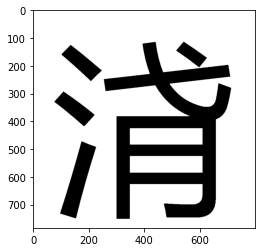

In [31]:
rawImage = image.imread('Images/tempChar.png')
plt.imshow(rawImage)

origShape = np.shape(rawImage)
simpleImage = np.ones((origShape[0], origShape[1])) #grayscale, pixels should be black or white (1 or 0)

blackMask = np.logical_or(rawImage[:,:,0]<.8, rawImage[:,:,1]<.8, rawImage[:,:,2]<.8) #white enough
simpleImage[blackMask] = 0 #black pixels, all others are white

plt.imshow(simpleImage, cmap="gray")

## Calculate "gravity" map for the image
Each pixel should now be a vector of where that pixel is being "pulled"
to calculate "gravity" for a *single* pixel every pixel in the image needs to be checked

Each vector should be a (y,x) vector

In [56]:
#some math needed here, but norm vector is v/|v|, where v = [diffY, diffX]
#then magnitude should be from grav which is 1/|v|^2, so final is v * 1/(|v|^3)
def singleGravVector(locStart, locEnd): # mass1*mass2 / d^2, let masses just be 1 each
    diffY = locEnd[0] - locStart[0]
    diffX = locEnd[1] - locStart[1]
    #return np.asarray([diffY, diffX]) * 1.0/(abs(diffY)+abs(diffX))
    return np.asarray([diffY, diffX]) * (1.0 / (math.dist([0,0], [diffY, diffX])**3) )

#get vector for one particular pixel by sum of vectors
def getPixelsVector(img, loc): #loc is y,x list
    finalVect = np.asarray([0.0,0.0]) #start with zero, just sum all vectors up
    
    imgSize = np.shape(img)
    for y in range(imgSize[0]):
        for x in range(imgSize[1]):
            if(img[y,x] == 0 and (y != loc[0] and x != loc[1])): #black
                finalVect += singleGravVector(loc, [y,x]) #calculate specific vector
            #if white pixel, no calc. needed
    return finalVect

#warning this is really slow
def getImageGravity(img):
    imgSize = np.shape(img)
    gravImg = np.zeros((imgSize[0], imgSize[1], 2)) #y,x, vector_y, vector_x
    
    for y in range(0,imgSize[0]):
        for x in range(0,imgSize[1]):
            gravImg[y,x,:] = getPixelsVector(img, [y,x]) #calculate the grav vector for this pixel
        print("Row", y, "of", imgSize[0], "is done.")
    return gravImg

In [65]:
gapDist = 13
gravImg = getImageGravity(simpleImage[int(gapDist/2)::gapDist,int(gapDist/2)::gapDist])
print(np.shape(gravImg))
print(np.shape(simpleImage))

Row 0 of 60 is done.
Row 1 of 60 is done.
Row 2 of 60 is done.
Row 3 of 60 is done.
Row 4 of 60 is done.
Row 5 of 60 is done.
Row 6 of 60 is done.
Row 7 of 60 is done.
Row 8 of 60 is done.
Row 9 of 60 is done.
Row 10 of 60 is done.
Row 11 of 60 is done.
Row 12 of 60 is done.
Row 13 of 60 is done.
Row 14 of 60 is done.
Row 15 of 60 is done.
Row 16 of 60 is done.
Row 17 of 60 is done.
Row 18 of 60 is done.
Row 19 of 60 is done.
Row 20 of 60 is done.
Row 21 of 60 is done.
Row 22 of 60 is done.
Row 23 of 60 is done.
Row 24 of 60 is done.
Row 25 of 60 is done.
Row 26 of 60 is done.
Row 27 of 60 is done.
Row 28 of 60 is done.
Row 29 of 60 is done.
Row 30 of 60 is done.
Row 31 of 60 is done.
Row 32 of 60 is done.
Row 33 of 60 is done.
Row 34 of 60 is done.
Row 35 of 60 is done.
Row 36 of 60 is done.
Row 37 of 60 is done.
Row 38 of 60 is done.
Row 39 of 60 is done.
Row 40 of 60 is done.
Row 41 of 60 is done.
Row 42 of 60 is done.
Row 43 of 60 is done.
Row 44 of 60 is done.
Row 45 of 60 is done

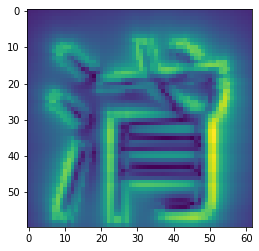

In [66]:
def getImageMagn(gravImg):
    vectImg = np.sqrt(gravImg[:,:,0]**2 + gravImg[:,:,1]**2)
    return vectImg
    
vectImg = getImageMagn(gravImg)
plt.imshow(vectImg)

## Way too slow
n^4 complexity is pretty bad, especialy when n = 800 (about 400 billion operations)

different strategy, precompute alot of vector directions and magnitudes

In [14]:
#compute each of the vectors from 0,0, then we can reuse these values with some modification
#should return an matrix, m, of the same size such that 
#m[y,x] = grav vector when diffY = y, diffX = x
def preComputedGravVect(imgShape):
    ims = imgShape
    preVect = np.zeros((ims[0], ims[1], 2)) #y, x, [y,x] vect
    coordY, coordX = np.meshgrid( np.arange(ims[1]) , np.arange(ims[0]) )
    #now preVectY[y,x] = y, preVectY[y,x] = x
    distMatr = np.sqrt(coordY**2 + coordX**2)
    preCompDistMatr = distMatr**3 #gravity math for the vector
    preCompDistMatr[0,0] = 1 #special case, gravity to itself is a zero vector, prevent div 0 error
    preVect[:,:,0] = coordX / preCompDistMatr #see previous section for this math
    preVect[:,:,1] = coordY / preCompDistMatr #see previous section for this math
    preVect[0,0,:] = [0,0] #special case, gravity to itself is a zero vector
    return preVect

#now armed with a preComputed matrix, we can figure out the total matrix for each pixel easier
def getImageGravity(img, jump=10): #pixWindow is how far we check for gravity in each dir
    imgSize = np.shape(img)
    blackPixelMask = img == 0
    preVect = preComputedGravVect(imgSize) #limit to pixWindow, saves computation time
    gravImg = np.zeros((imgSize[0], imgSize[1], 2)) #y,x, vector_y, vector_x
    
    for y in range(0,imgSize[0],jump):
        for x in range(0,imgSize[1],jump):
            overlay = getPreVectOverlay([y,x], preVect)
            gravImg[y,x,0] = np.sum(overlay[:,:,0][blackPixelMask]) #sum all grav vectors for black pixels
            gravImg[y,x,1] = np.sum(overlay[:,:,1][blackPixelMask])
            #we need to overlay the preVect over the image shifted properly
        print("Progress:", 100*(y/imgSize[0]), "\b%")
    return gravImg

#for an y,x position, get the right filter with the preComp vect
def getPreVectOverlay(loc, preVect):
    y, x = loc
    yD, xD, _ = np.shape(preVect) #get y and x dimensions
    overlayVect = np.zeros(np.shape(preVect))
    #first quadrant, y pos, x pos
    #at y,x we should use preVect[0,0], at y+1,x+2 use preVect[1,2]
    overlayVect[y:,x:] = preVect[:yD-y,:xD-x] #quadrant 1, simple pos y, pos x
    overlayVect[:y+1,:x+1] = -1*np.flip(preVect[:y+1,:x+1]) #quadrant 3, neg y, neg x (vect should be neg)
    #quadrants 2,4 require flipping one of the vect dims
    overlayVect[y:,:x+1, 0] = np.flip(preVect[:yD-y,:x+1,0], axis=1) #quadrant 2, pos y
    overlayVect[y:,:x+1, 1] = -1*np.flip(preVect[:yD-y,:x+1,1], axis=1) #quadrant 2, neg x
    overlayVect[:y+1,x:, 0] = -1*np.flip(preVect[:y+1,:xD-x,0], axis=0) #quadrant 4, neg y
    overlayVect[:y+1,x:, 1] = np.flip(preVect[:y+1,:xD-x,1], axis=0) #quadrant 4, pos x

    return overlayVect
    

Progress: 0.0%
Progress: 1.6666666666666667%
Progress: 3.3333333333333335%
Progress: 5.0%
Progress: 6.666666666666667%
Progress: 8.333333333333332%
Progress: 10.0%
Progress: 11.666666666666666%
Progress: 13.333333333333334%
Progress: 15.0%
Progress: 16.666666666666664%
Progress: 18.333333333333332%
Progress: 20.0%
Progress: 21.666666666666668%
Progress: 23.333333333333332%
Progress: 25.0%
Progress: 26.666666666666668%
Progress: 28.333333333333332%
Progress: 30.0%
Progress: 31.666666666666664%
Progress: 33.33333333333333%
Progress: 35.0%
Progress: 36.666666666666664%
Progress: 38.333333333333336%
Progress: 40.0%
Progress: 41.66666666666667%
Progress: 43.333333333333336%
Progress: 45.0%
Progress: 46.666666666666664%
Progress: 48.333333333333336%
Progress: 50.0%
Progress: 51.66666666666667%
Progress: 53.333333333333336%
Progress: 55.00000000000001%
Progress: 56.666666666666664%
Progress: 58.333333333333336%
Progress: 60.0%
Progress: 61.66666666666667%
Progress: 63.33333333333333%
Progress

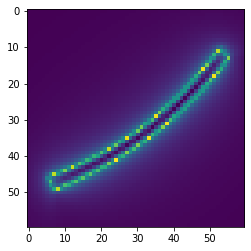

In [17]:
jump = 10
gravImg = getImageGravity(simpleImage[100:700,100:700], jump=jump)
finalImg = getImageMagn(gravImg)
plt.imshow(finalImg[::jump,::jump])

## Decompose vectors
For each gravity vector, we need to break it down into the (normal?) and (tangent?) vectors, one is used to decide the movement of the vector the other rotation (but not sure if we'll use that)

Suppose we know 

Center of mass: $c = [c_y, c_x]$

Point we calculate gravity for $p = [p_y, p_x]$

Gravity vector $g = [g_y, g_x]$

Then we can determine:

The basic normal vector (we'll determine magnitude shortly): $n_b = c - p$

Actual normal vector: $n = \frac{n_b g}{\vert n_b \vert} n_b$

Tangent vector: $t = g - n$

In [13]:
def decomposeVect(c, p, gravV): #center and curr position, then vector
    c = np.array(c)
    p = np.array(p)
    nb = c - p
    n =  (nb[0]*g[0] + nb[1]*g[1])/(np.sqrt(coordY**2 + coordX**2))